# Data Analysis and Train

## Reading tsv

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv("train.tsv",sep="\t", index_col=0)

## Removing Duplicates

In [2]:
print(data.shape)
data = data.drop_duplicates()
print(data.shape)


(156060, 3)
(156060, 3)


## FillNA and Drop

In [3]:
data = data.fillna(method='ffill')
print(data.shape)
data.dropna(subset=['Phrase', 'Sentiment'])
print(data.shape)

(156060, 3)
(156060, 3)


## Removing Stop Words

In [4]:
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['Phrase'] = data.Phrase.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
display(data.head(2))

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,A series escapades demonstrating adage good go...,1
2,1,A series escapades demonstrating adage good goose,2


## To lower data

In [5]:
data['Phrase'] = data.Phrase.apply(lambda x: x.lower())
display(data.head(2))

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,a series escapades demonstrating adage good go...,1
2,1,a series escapades demonstrating adage good goose,2


## Tokenizer data

In [6]:
from nltk.tokenize import sent_tokenize, word_tokenize
#train['new_Phrase2'] = train['new_Phrase'].apply(lambda x: sent_tokenize(x))

data['new_Phrase'] = data.Phrase.apply(lambda x: word_tokenize(x))
display(data.head(4))

,SentenceId,Phrase,Sentiment,new_Phrase
PhraseId,,,,
1,1,a series escapades demonstrating adage good go...,1,"[a, series, escapades, demonstrating, adage, g..."
2,1,a series escapades demonstrating adage good goose,2,"[a, series, escapades, demonstrating, adage, g..."
3,1,a series,2,"[a, series]"
4,1,a,2,[a]


## Removing Punctuation

In [7]:
import re

nonPunct = re.compile('.*[A-Za-z0-9].*')  # must contain a letter or digit
#nonPunct = re.compile('.*[A-Za-z].*')  # must contain a letter
data['new_Phrase2'] = data.new_Phrase.apply(lambda x: [w for w in x if nonPunct.match(w)])
display(data.head(5))

,SentenceId,Phrase,Sentiment,new_Phrase,new_Phrase2
PhraseId,,,,,
1,1,a series escapades demonstrating adage good go...,1,"[a, series, escapades, demonstrating, adage, g...","[a, series, escapades, demonstrating, adage, g..."
2,1,a series escapades demonstrating adage good goose,2,"[a, series, escapades, demonstrating, adage, g...","[a, series, escapades, demonstrating, adage, g..."
3,1,a series,2,"[a, series]","[a, series]"
4,1,a,2,[a],[a]
5,1,series,2,[series],[series]


## Removing empty values

In [8]:
def identify_empty(x):
    if x == []:
        return 0
    else:
        return 1
data['to_remove'] = data.new_Phrase2.apply(lambda x: identify_empty(x))

In [9]:
print(data.shape)
data = data[data.to_remove == 1]
data = data[['new_Phrase2', 'Sentiment', 'SentenceId']]
print(data.shape)

(156060, 6)
(155108, 3)


## Value Counts

In [10]:
data.Sentiment.value_counts()

2    78696
3    32880
1    27254
4     9206
0     7072
Name: Sentiment, dtype: int64

## Stratifying Data

In [11]:
data['Phrase'] = data.new_Phrase2.apply(lambda x: ' '.join(x))
X = data.Phrase
y = data.Sentiment
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Creating TF - IDF (Using n-gram 1,3)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
x_train_tfidf = tvec.fit_transform(X_train)
x_validation_tfidf = tvec.transform(X_validation)


## Define function to plot mais features

In [17]:
from sklearn.feature_selection import chi2
def plot_chi2(x, y):
    chi2score = chi2(x, y)[0]
    wscores = zip(tvec.get_feature_names(), chi2score)
    wchi2 = sorted(wscores, key=lambda x:x[1])
    topchi2 = wchi2[::-1][:40]
    labels =  np.array(topchi2)[:,0]
    
    y_pos = range(0,len(topchi2))
    plt.figure(figsize=(12,10))
    chi_values = [round(float(i),2) for i in list(np.array(topchi2)[:,1])]

    plt.bar(y_pos, chi_values , align='center', alpha=0.5)
    plt.xticks(y_pos, np.array(topchi2)[:,0],rotation='vertical')
    plt.plot(y_pos, chi_values, '-o', markersize=5, alpha=0.8)
    plt.ylabel('Chi2')
    plt.xlabel('Top tokens')
    plt.title('Top tokens')
    plt.show()

## Plot main variables for each class, using chi²

0    118429
1      5657
Name: y, dtype: int64


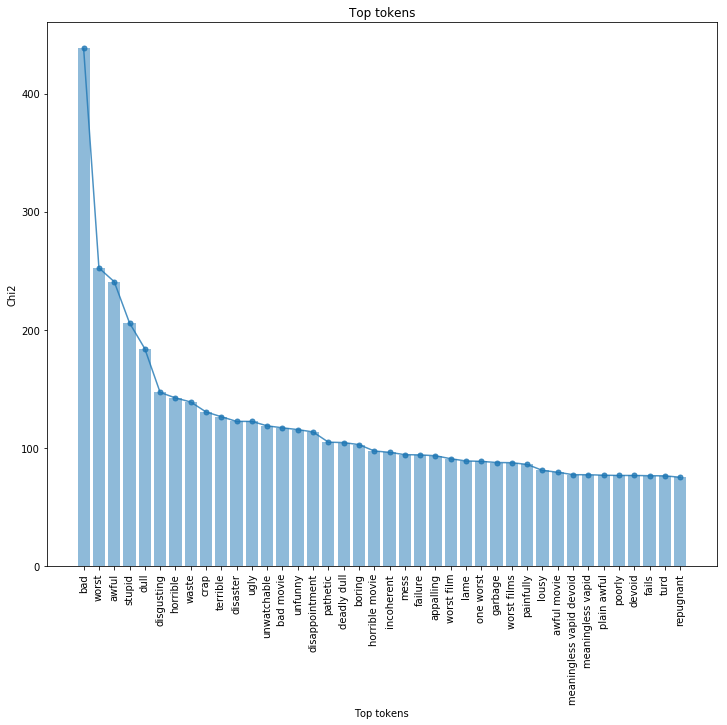

0    102283
1     21803
Name: y, dtype: int64


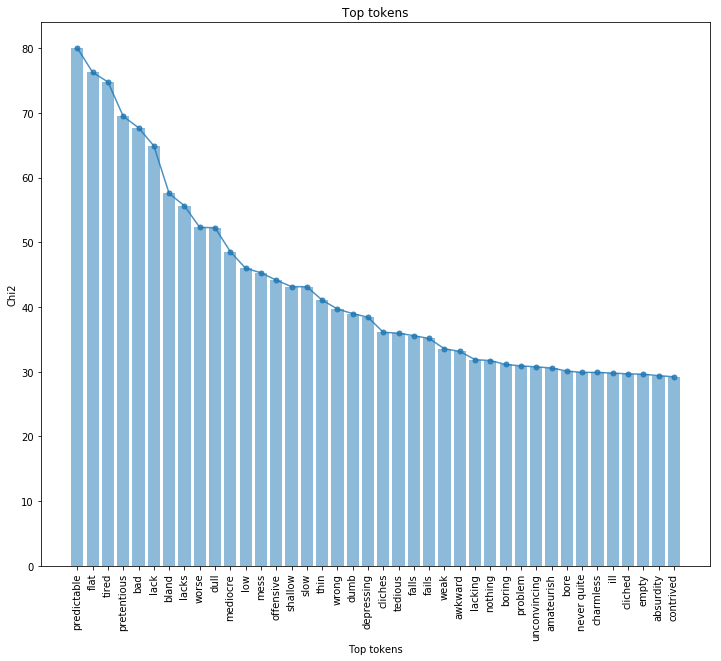

1    62957
0    61129
Name: y, dtype: int64


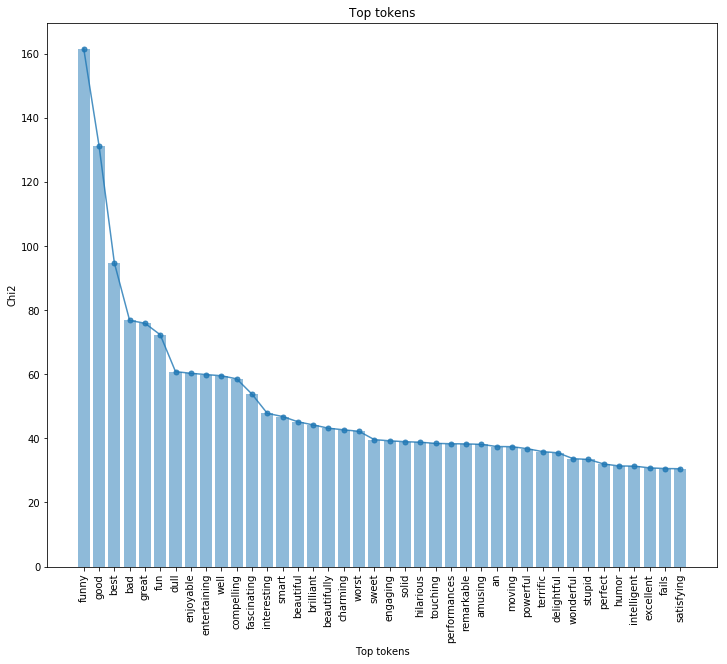

0    97782
1    26304
Name: y, dtype: int64


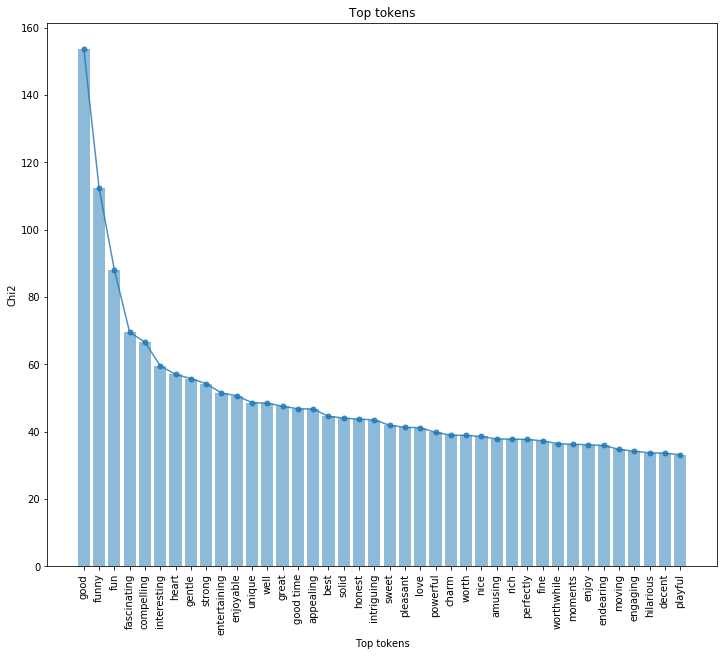

0    116721
1      7365
Name: y, dtype: int64


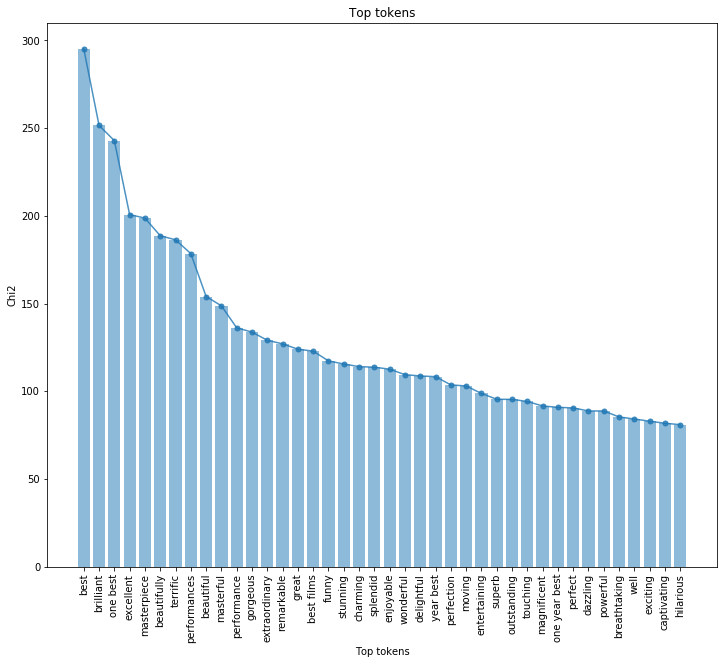

In [18]:
import numpy as np
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
for i in range(0,5):
    data_train = pd.DataFrame({"X":x_train_tfidf,"y": y_train})
    data_train.y = data_train.y+10
    inds = sorted(list(data_train.y.value_counts().index))
    
    for j in range(0,len(inds)):
        if i == j:
            data_train.y[data_train['y'] == inds[j]] = 1
        else:
            data_train.y[data_train['y'] == inds[j]] = 0
    print(data_train.y.value_counts())
    
    plot_chi2(x_train_tfidf, data_train.y)

## Word Cloud

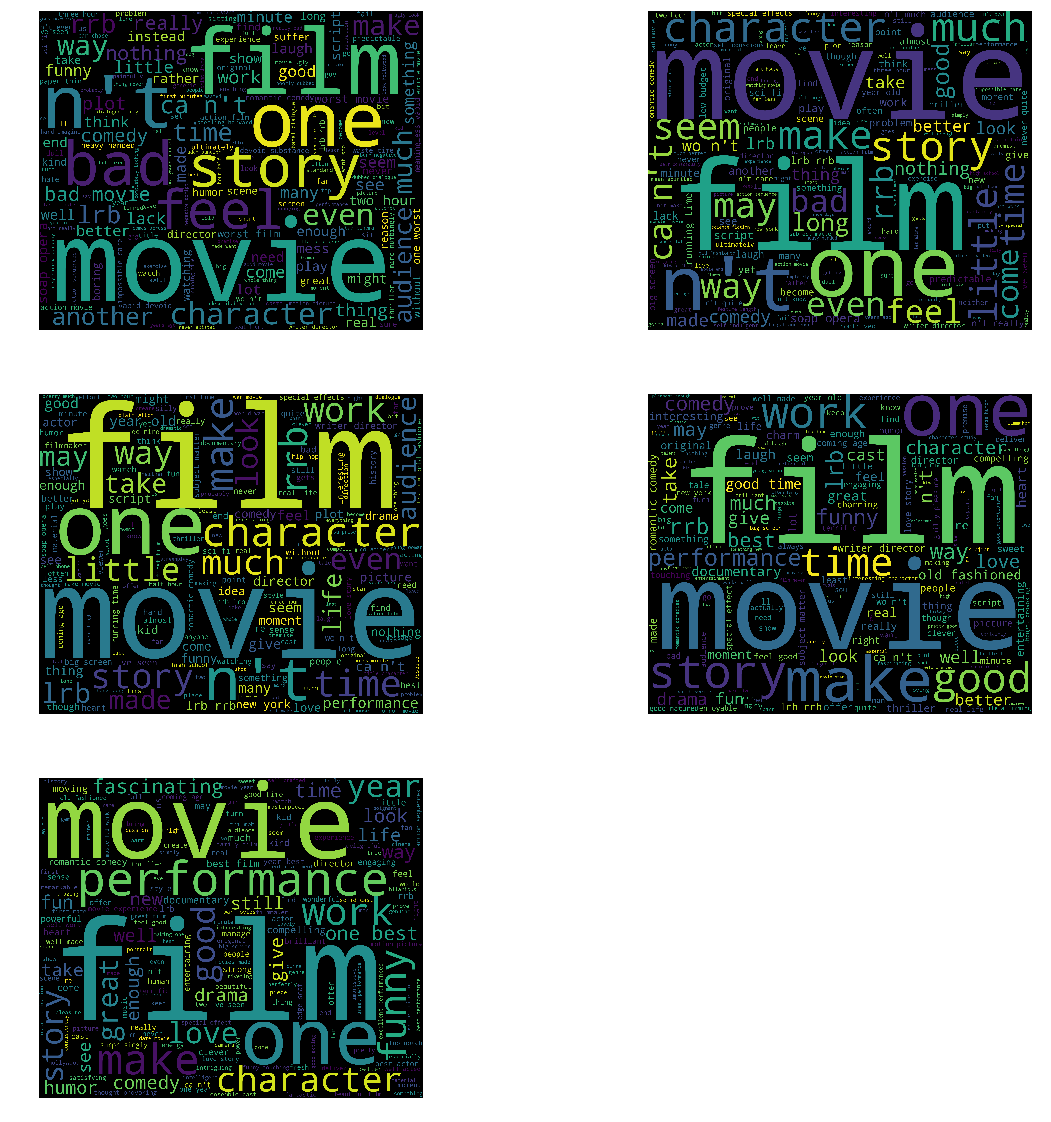

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

d = {}
plt.figure(1,figsize=(20, 20))
for i in range(0,5):
    d[i] = data[data.Sentiment==i]
    words = ' '.join(d[i]['Phrase'])
    split_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(background_color='black',width=3000,height=2500).generate(split_word)
    plt.subplot(320+(i+1))
    plt.imshow(wordcloud)
    plt.axis('off')
plt.show()

## Getting best features using chi

In [20]:
from sklearn.feature_selection import SelectKBest, chi2
ch2_result = []
n = 10000
ch2 = SelectKBest(chi2, k=n)
x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
x_validation_chi2_selected = ch2.transform(x_validation_tfidf)

## Train model using chi² features

In [21]:
from sklearn.ensemble import RandomForestClassifier
Sentiment_model = RandomForestClassifier(n_estimators=25)
Sentiment_model.fit(x_train_chi2_selected, y_train)
score = Sentiment_model.score(x_validation_chi2_selected, y_validation)
print(score)

0.6260718199987106


## Prediction and evaluate

In [22]:
from sklearn.metrics import classification_report

predictions = Sentiment_model.predict(x_validation_chi2_selected)
report = classification_report(y_validation, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.44      0.37      0.40      1415
           1       0.53      0.41      0.47      5451
           2       0.69      0.82      0.75     15739
           3       0.55      0.45      0.49      6576
           4       0.49      0.40      0.44      1841

   micro avg       0.63      0.63      0.63     31022
   macro avg       0.54      0.49      0.51     31022
weighted avg       0.61      0.63      0.61     31022



In [23]:
from sklearn.metrics import confusion_matrix
cmat_best = confusion_matrix(y_validation, predictions)
print(cmat_best)

[[  527   565   279    40     4]
 [  512  2256  2462   207    14]
 [  133  1210 12930  1372    94]
 [   21   181  2742  2968   664]
 [    3    31   220   846   741]]


## Saving Models

In [26]:
import pickle
pickle.dump( Sentiment_model, open("Sentiment_model_chi.pkl", "wb" ))
pickle.dump( tvec, open("tvec_chi.pkl", "wb" ))
pickle.dump( ch2, open("chi.pkl", "wb" ))